In [35]:
# import all the tools we need
import urllib
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import draw_bounding_boxes

import os 
from PIL import Image
import random
import xml.etree.ElementTree as ET
import time
import requests

In [36]:
img_dir = '../input/face-mask-detection/images'
xml_dir = '../input/face-mask-detection/annotations'

img_list = sorted(os.listdir(dir_path))
xml_list = sorted(os.listdir(xml_path))
print(len(img_list))

853


In [37]:
def read_img(img_name, dir_path):
    # img  = Image.open(os.path.join(dir_path, img_name)).convert('RGB')
    img = plt.imread(os.path.join(dir_path, img_name))
    img = img[:,:,:3]
    return(img)

def read_annot(xml_name, xml_dir):
    bbox = []
    labels = [] 
    annot_path = os.path.join(xml_dir, xml_name)
    tree = ET.parse(annot_path)
    root = tree.getroot()
    for boxes in root.iter('object'):
        ymin = int(boxes.find("bndbox/ymin").text)
        xmin = int(boxes.find("bndbox/xmin").text)
        ymax = int(boxes.find("bndbox/ymax").text)
        xmax = int(boxes.find("bndbox/xmax").text)
        label = boxes.find('name').text
        bbox.append([xmin,ymin,xmax,ymax])
        if label == 'with_mask':
            label_idx = 2
        else:
            label_idx = 1
        labels.append(label_idx)
    return bbox, labels

def draw_boxes(img, boxes,labels, thickness=1):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    for box,label in zip(boxes,labels):
        box = [int(x) for x in box]
        if label == 2:
            color = (0,225,0) # green
        elif label == 1:
            color = (0,0,225) # red
        cv2.rectangle(img, (box[0],box[1]),(box[2],box[3]),color,thickness)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

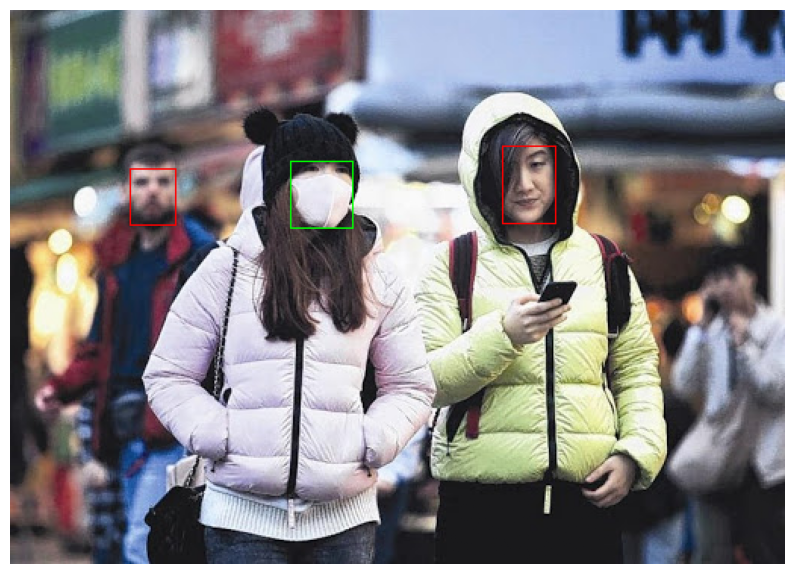

In [38]:
img = read_img(img_list[0], img_dir) # random select an image
bbox, labels  = read_annot(xml_list[0], xml_dir)
img_box = draw_boxes(img, bbox,labels)
    
# display the image
fig, ax = plt.subplots(1,1,figsize=(10,10))
plt.axis('off')
ax.imshow(img_box)

In [39]:
class image_dataset(Dataset):
    def __init__(self, image_list, image_dir, xml_list, xml_dir):
        self.image_list = image_list
        self.image_dir = image_dir
        self.xml_list = xml_list
        self.xml_dir = xml_dir

    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, idx):
        img_name = self.image_list[idx]
        img_path = os.path.join(self.image_dir, img_name)
        img = Image.open(img_path).convert('RGB')
        img = transforms.ToTensor()(img)
        
        xml_name = self.xml_list[idx]
        bbox, labels = read_annot(xml_name, self.xml_dir)
        boxes = torch.as_tensor(bbox, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        area = (boxes[:,2] - boxes[:,0]) * (boxes[:,3] - boxes[:,1])
        area = torch.as_tensor(area, dtype=torch.float32)
        iscrowd = torch.zeros((len(bbox),), dtype=torch.int64)
        
        target = {}
        
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([idx])
        target['area'] = area
        target['iscrowed'] = iscrowd
        return img , target

In [40]:
mask_dataset = image_dataset(img_list, img_dir,xml_list, xml_dir)

def collate_fn(batch):
    return tuple(zip(*batch))

mask_loader = DataLoader(mask_dataset,
                        batch_size=2,
                        shuffle=True,
                        collate_fn=collate_fn
)
img, target = next(iter(mask_loader))
print(target[0])

{'boxes': tensor([[ 83.,  56., 117.,  95.],
        [179.,  51., 212.,  87.],
        [263.,  62., 295., 101.]]), 'labels': tensor([2, 2, 2]), 'image_id': tensor([295]), 'area': tensor([1326., 1188., 1248.]), 'iscrowed': tensor([0, 0, 0])}


# Faster RCNN model

## 1. Pretrained model 

In [41]:
num_classes = 3 # background, without_mask, with_mask

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.eval()
result = model(img)
print(model)
result[1]['labels'].shape

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

torch.Size([100])

In [42]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)
for param in model.backbone.parameters():
    param.requires_grad = False
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01,momentum=0.9, weight_decay=0.0005)
num_epochs=3

loss_list = []
for epoch in range(num_epochs):
    loss_sub_list = []
    for images, targets in mask_loader:
        images = list(image.to(device) for image in images)
        targets = [{k:v.to(device) for k,v in t.items()} for t in targets]
        model.train()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_sub_list.append(losses.item())
        
        # update optimizer and learning rate
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
    #print the loss of epoch
    epoch_loss = np.mean(loss_sub_list)
    loss_list.append(epoch_loss)
    print('Epoch loss: {:.3f}'.format(epoch_loss))

Epoch loss: 0.475
Epoch loss: 0.378
Epoch loss: 0.352


## 2. Predict image with bboxes and labels

In [43]:
def img_predict(img):
    test_img = transforms.ToTensor()(img)
    
    model.eval()
    with torch.no_grad():
        predictions = model(test_img.unsqueeze(0).to(device))
        
    keep_boxes = torchvision.ops.nms(boxes = predictions[0]['boxes'].cpu(),
                                     scores = predictions[0]['scores'].cpu(),
                                     iou_threshold = 0.3)
    score_filter = predictions[0]['scores'].cpu().numpy()[keep_boxes] > 0.8 #score_thrs
    
    test_boxes = predictions[0]['boxes'].cpu().numpy()[keep_boxes][score_filter]
    test_labels = predictions[0]['labels'].cpu().numpy()[keep_boxes][score_filter]
    
    return test_img, test_boxes, test_labels

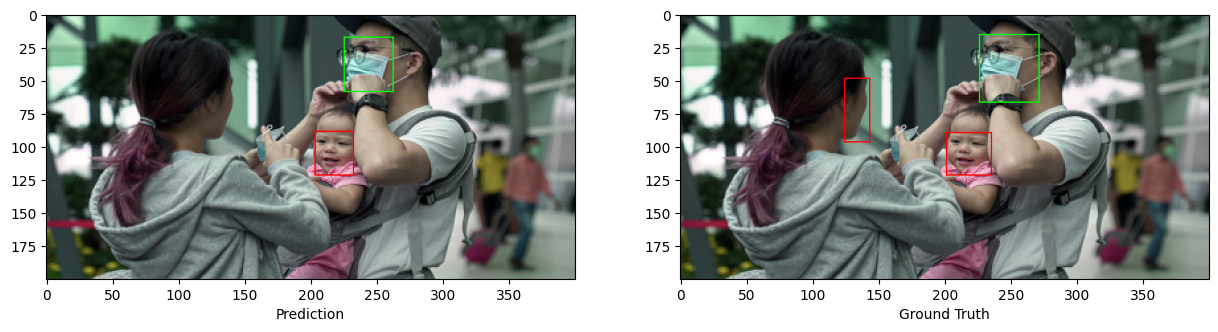

In [44]:
#idx = random.randint(1,len(file_list))
idx = 100
test_img = Image.open(os.path.join(img_dir,img_list[idx])).convert('RGB')

# Prediction
test_img, test_boxes, test_labels = img_predict(test_img)
test_img = test_img.permute(1,2,0).numpy() # the draw funct take numpy img(H,W,C = 3) thus, the PIL in (C,H,W) back to (H,W,C)
test_output = draw_boxes(test_img, test_boxes,test_labels)

# Draw the bounding box of ground truth
bbox, labels  = read_annot(xml_list[idx], xml_dir)
gt_output = draw_boxes(test_img, bbox,labels)

# Display the result
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,6))
ax1.imshow(test_output)
ax1.set_xlabel('Prediction')
ax2.imshow(gt_output)
ax2.set_xlabel('Ground Truth')
plt.show()